<a href="https://colab.research.google.com/github/kishimoto-banana/deep-painterly-harmonization/blob/master/deep_painterly_harmonization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.conv_learner import *

In [9]:
!ls

16_c_mask_dilated.jpg  16_c_mask.jpg  16_naive.jpg  16_target.jpg  sample_data


In [0]:
PATH = Path('.')

In [0]:
idx = 16
input_img = open_image(PATH/f'{idx}_naive.jpg')
style_img = open_image(PATH/f'{idx}_target.jpg')
mask = open_image(PATH/f'{idx}_c_mask.jpg')
loose_mask = open_image(PATH/f'{idx}_c_mask_dilated.jpg')

(-0.5, 699.5, 556.5, -0.5)

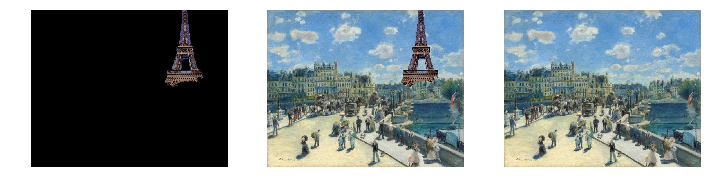

In [13]:
fig, axs = plt.subplots(1,3,figsize = (12,6))
axs[0].imshow(input_img * mask)
axs[0].axis('off')
axs[1].imshow(input_img)
axs[1].axis('off')
axs[2].imshow(style_img)
axs[2].axis('off')

In [0]:
def dilate_mask(mask):
    loose_mask = cv2.GaussianBlur(mask, (35,35) , 35/3)
    loose_mask[loose_mask>=0.1] = 1
    return loose_mask

In [0]:
loose_mask1 = dilate_mask(mask)

(-0.5, 699.5, 556.5, -0.5)

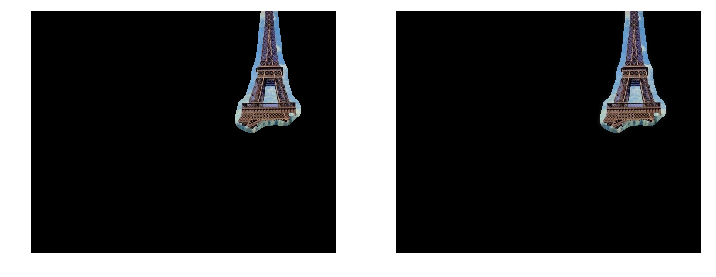

In [16]:
fig, axs = plt.subplots(1,2,figsize = (12,6))
axs[0].imshow(input_img * loose_mask)
axs[0].axis('off')
axs[1].imshow(input_img * loose_mask1)
axs[1].axis('off')

In [0]:
mask_smth = cv2.GaussianBlur(mask, (3,3) , 1)

In [0]:
trn_tfms, val_tfms = tfms_from_model(vgg16, 500, crop_type=CropType.NO)

In [0]:
val_tfms.tfms = val_tfms.tfms[2:]

In [0]:
input_tfm = val_tfms(input_img)
style_tfm = val_tfms(style_img)

In [21]:
layers = cut_model(vgg16(True),37) #43 vor VGG19
m_vgg = to_gpu(nn.Sequential(*layers)).eval()
set_trainable(m_vgg, False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.torch/models/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:10<00:00, 53703005.69it/s]


In [0]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

In [23]:
m_vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (16): ReLU(inplace)
  (17): Conv2d(256, 256, ke

In [0]:
idx_layers = [16,26,36] #[16, 29, 42] for VGG19

In [0]:
class SaveFeatures(nn.Module):
    features = None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

In [0]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in idx_layers]

In [29]:
m_vgg(VV(input_tfm[None]))
input_ftrs = [s.features for s in sfs]
[sf.shape for sf in input_ftrs]

[torch.Size([1, 256, 139, 175]),
 torch.Size([1, 512, 69, 87]),
 torch.Size([1, 512, 34, 43])]

In [30]:
m_vgg(VV(style_tfm[None]))
style_ftrs = [s.features for s in sfs]
[sf.shape for sf in style_ftrs]

[torch.Size([1, 256, 139, 175]),
 torch.Size([1, 512, 69, 87]),
 torch.Size([1, 512, 34, 43])]

In [0]:
def halve_size(mask):
    h,w = mask.shape
    return cv2.resize(mask, (w//2,h//2))

In [0]:
ConvolMask = nn.AvgPool2d(3, 1, 1)
def convol(mask, nb):
    x = V(mask[None][None])
    for i in range(nb): x = ConvolMask(x)
    return to_np(x.data.squeeze())

In [0]:
def get_mask_ftrs(mask):
    ftrs = []
    mask = halve_size(convol(mask,2))
    mask = halve_size(convol(mask,2))
    mask = convol(mask,1)
    ftrs.append(mask)
    mask = halve_size(convol(mask,2))#3 for VGG19
    mask = convol(mask,1)
    ftrs.append(mask)
    mask = halve_size(convol(mask,2))#3 for VGG19
    mask = convol(mask,1)
    ftrs.append(mask)
    return ftrs

In [34]:
mask_ftrs = get_mask_ftrs(loose_mask[:,:,0])
[mf.shape for mf in mask_ftrs]

[(139, 175), (69, 87), (34, 43)]

In [0]:
def get_patches(x,ks=3,stride=1,padding=1):
    ch, n1, n2 = x.shape
    y = np.zeros((ch,n1+2*padding,n2+2*padding))
    y[:,padding:n1+padding,padding:n2+padding] = x
    start_idx = np.array([j + (n2+2*padding)*i for i in range(0,n1-ks+1+2*padding,stride) for j in range(0,n2-ks+1+2*padding,stride) ])
    grid = np.array([j + (n2+2*padding)*i + (n1+2*padding) * (n2+2*padding) * k for k in range(0,ch) for i in range(ks) for j in range(ks)])
    to_take = start_idx[:,None] + grid[None,:]
    return y.take(to_take)

In [0]:
def match_ftrs(inp_ftrs,sty_ftrs):
    res = []
    for l_inp,s_inp in zip(inp_ftrs,sty_ftrs):
        l_inp = VV(get_patches(to_np(l_inp[0].data)))
        s_inp = VV(get_patches(to_np(s_inp[0].data)))
        scals = torch.mm(l_inp,s_inp.t())
        norms_in = torch.sqrt((l_inp ** 2).sum(1))
        norms_st = torch.sqrt((s_inp ** 2).sum(1))
        cosine_sim = scals / (1e-15 + norms_in.unsqueeze(1) * norms_st.unsqueeze(0))
        _, idx_max = cosine_sim.max(1)
        res.append(to_np(idx_max))
    return res

In [0]:
map_ftrs = match_ftrs(input_ftrs, style_ftrs)

In [0]:
def map_style():
    res = []
    for sf, mapf in zip(style_ftrs, map_ftrs):
        sf = to_np(sf).reshape(sf.size(1),-1)
        sf = sf[:,mapf]
        res.append(VV(sf))
    return res

In [0]:
sty_ftrs = map_style()

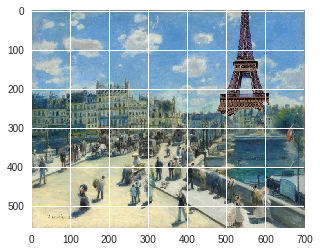

In [41]:
opt_img = input_tfm.copy()
plt.imshow(val_tfms.denorm(to_np(opt_img).transpose(1,2,0)));

In [43]:
opt_img_v = V(opt_img[None], requires_grad=True)
opt_img_v.shape

torch.Size([1, 3, 557, 700])

In [0]:
max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=1)

In [0]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter += 1
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss

In [0]:
def content_loss(out_ftrs):
    msk_of = out_ftrs * V(mask_ftrs[1][None,None], requires_grad=False)
    msk_if = input_ftrs[1] * V(mask_ftrs[1][None,None], requires_grad=False)
    return F.mse_loss(msk_of,msk_if, size_average=False) / float(out_ftrs.size(1) * mask_ftrs[1].sum())

In [0]:
def gram(input):
    x = input
    return torch.mm(x, x.t())

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

In [0]:
def style_loss(out_ftrs):
    loss = 0
    for of, sf, mf in zip(out_ftrs, sty_ftrs, mask_ftrs):
        to_pass = of * V(mf[None,None], requires_grad=False)
        to_pass = to_pass.view(to_pass.size(1),-1)
        sf = sf * V(mf, requires_grad=False).view(1,-1)
        loss += gram_mse_loss(to_pass,sf)
    return loss / 3

In [0]:
w_c, w_s = 1, 10

In [0]:
def stage1_loss(opt_img_v):
    m_vgg(opt_img_v)
    out_ftrs = [o.features for o in sfs]
    c_loss = content_loss(out_ftrs[1])
    s_loss = style_loss(out_ftrs)
    return w_c * c_loss + w_s * s_loss

In [52]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,stage1_loss))

Iteration: 100, loss: 1.0702763795852661
Iteration: 200, loss: 0.6735218167304993
Iteration: 300, loss: 0.5430194735527039
Iteration: 400, loss: 0.4774240553379059
Iteration: 500, loss: 0.44006675481796265
Iteration: 600, loss: 0.41314905881881714
Iteration: 700, loss: 0.3935489356517792
Iteration: 800, loss: 0.37894946336746216
Iteration: 900, loss: 0.36756327748298645
Iteration: 1000, loss: 0.35860732197761536


(-0.5, 699.5, 556.5, -0.5)

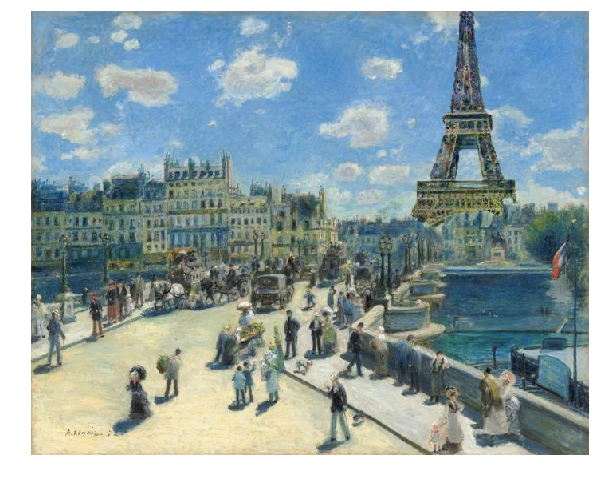

In [54]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
out_img = val_tfms.denorm(to_np(opt_img_v.data)[0].transpose(1,2,0))
out_img = out_img * mask_smth + style_img * (1-mask_smth)
out_img = out_img.clip(0, 1) #Pixel values shouldn't get below 0 or be greater than 1.
ax.imshow(out_img)
ax.axis('off')

In [0]:
np.save(PATH/f'{idx}_stage1.npy', out_img)

In [0]:
stage1_img = np.load(PATH/f'{idx}_stage1.npy')
stage1_tfm = val_tfms(stage1_img)

In [0]:
idx_layers = [2, 9, 16,26] #[2,9,16,29] for VGG19

In [0]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in idx_layers]

In [101]:
m_vgg(VV(input_tfm[None]))
input_ftrs = [s.features for s in sfs]
[sf.shape for sf in input_ftrs]

[torch.Size([1, 64, 557, 700]),
 torch.Size([1, 128, 278, 350]),
 torch.Size([1, 256, 139, 175]),
 torch.Size([1, 512, 69, 87])]

In [102]:
m_vgg(VV(stage1_tfm[None]))
stage1_ftrs = [s.features for s in sfs]
[sf.shape for sf in stage1_ftrs]

[torch.Size([1, 64, 557, 700]),
 torch.Size([1, 128, 278, 350]),
 torch.Size([1, 256, 139, 175]),
 torch.Size([1, 512, 69, 87])]

In [103]:
m_vgg(VV(style_tfm[None]))
style_ftrs = [s.features for s in sfs]
[sf.shape for sf in style_ftrs]

[torch.Size([1, 64, 557, 700]),
 torch.Size([1, 128, 278, 350]),
 torch.Size([1, 256, 139, 175]),
 torch.Size([1, 512, 69, 87])]

In [0]:
def get_mask_ftrs_st2(mask):
    ftrs = []
    mask = convol(mask,1)
    ftrs.append(mask)
    mask = halve_size(convol(mask,1))
    mask = convol(mask,1)
    ftrs.append(mask)
    mask = halve_size(convol(mask,1))
    mask = convol(mask,1)
    ftrs.append(mask)
    mask = halve_size(convol(mask,2))#3 for VGG19
    mask = convol(mask,1)
    ftrs.append(mask)
    return ftrs

In [105]:
mask_ftrs = get_mask_ftrs_st2(loose_mask[:,:,0])
[mf.shape for mf in mask_ftrs]

[(557, 700), (278, 350), (139, 175), (69, 87)]

In [0]:
def match_ftrs_st2(inp_ftrs,sty_ftrs):
    l_inp = VV(get_patches(to_np(inp_ftrs[0].data)))
    s_inp = VV(get_patches(to_np(sty_ftrs[0].data)))
    scals = torch.mm(l_inp,s_inp.t())
    norms_in = torch.sqrt((l_inp ** 2).sum(1))
    norms_st = torch.sqrt((s_inp ** 2).sum(1))
    cosine_sim = scals / (1e-15 + norms_in.unsqueeze(1) * norms_st.unsqueeze(0))
    _, idx_max = cosine_sim.max(1)
    return to_np(idx_max)

In [0]:
first_map = match_ftrs_st2(stage1_ftrs[-1], style_ftrs[-1])

In [108]:
first_map.shape

(6003,)

In [0]:
n_size = 5
n_rad = n_size//2
neighbors = [np.array([i,j]) for i in range(-n_rad,n_rad+1) for j in range(-n_rad,n_rad+1)]

In [0]:
def apply_neighbor(idx, ngb, size):
    n1,n2 = size
    coords = np.array([idx//n2,idx%n2]) + ngb
    if coords[0] >= 0 and coords[0] < n1 and coords[1] >= 0 and coords[1] < n2:
        return coords[0] * n2 + coords[1]
    else: return -1

In [0]:
def second_match(init_map, sty_ftrs, mask, ks = 5):
    ch, n1, n2 = sty_ftrs.shape
    rad = (ks-1)//2
    sty_ftrs = np.reshape(sty_ftrs, (ch,n1*n2)).transpose()
    result = init_map.copy()
    for i in range(n1*n2):
        if mask[i] <= 0.1: continue
        candidates = []
        style_neighbors = []
        for ngb in neighbors:
            i1 = apply_neighbor(i, ngb, (n1,n2))
            if i1 != -1:
                #style_neighbors.append(init_map[i1])#Original article
                j = apply_neighbor(init_map[i1], -ngb, (n1,n2))
                if j != -1: 
                    candidates.append(j)
                    style_neighbors.append(j)#Their code
        candidates = list(set(candidates)) #Get rid of the repetitions in the candidates to speed up a bit.
        if len(candidates) <= 1:
            if len(candidates) == 0:
                pdb.set_trace()
            if candidates[0] != i:
                pdb.set_trace()
            continue
        cand_ftrs = np.take(sty_ftrs, candidates, axis=0)
        ngbr_ftrs = np.take(sty_ftrs, style_neighbors, axis=0)
        dists = ((cand_ftrs[:,None] - ngbr_ftrs[None,:]) ** 2).sum(axis=2).sum(axis=1)
        result[i] = candidates[dists.argmin()]
    return result

In [0]:
style_rsz = cv2.resize(style_img,(style_ftrs[-1].size(3), style_ftrs[-1].size(2)))
t_mask = cv2.resize(mask, (style_ftrs[-1].size(3), style_ftrs[-1].size(2)), interpolation=cv2.INTER_NEAREST)[:,:,0]
style_rs_tfm, _ = val_tfms(style_rsz,mask)
second_map = second_match(first_map, style_rs_tfm, t_mask.reshape(-1)) #their code

In [0]:
def upsample(ref_map, ref_size, new_size):
    r_h, r_w = ref_size
    n_h, n_w = new_size
    new_map = np.zeros(n_h * n_w).astype(np.int32)
    ratio_h, ratio_w = n_h/r_h, n_w/r_w
    for i in range(n_h * n_w):
        n_x, n_y = i//n_w, i%n_w
        r_x, r_y = int((0.5+n_x) / ratio_h), int((0.5+n_y)/ratio_w)
        r_x, r_y = min(max(0,r_x),r_h-1), min(max(0,r_y),r_w-1)
        style_idx = ref_map[r_x * r_w + r_y]
        s_x = int(n_x + (style_idx//r_w - r_x) * ratio_h + 0.5)
        s_y = int(n_y + (style_idx%r_w - r_y) * ratio_w + 0.5)
        s_x, s_y = min(max(0,s_x),n_h-1), min(max(0,s_y),n_w-1)
        new_map[i] = s_x * n_w + s_y
    return new_map

In [0]:
map_ftrs = [upsample(second_map, mask_ftrs[-1].shape, mf.shape) for mf in mask_ftrs[:-1]] + [second_map]

In [115]:
tmask_ftrs = [t_mask]
for sf in style_ftrs[-2::-1]:
    rsz_mask = cv2.resize(tmask_ftrs[0], (sf.size(3), sf.size(2)), interpolation=cv2.INTER_NEAREST)
    tmask_ftrs.insert(0,rsz_mask)
[tmf.shape for tmf in tmask_ftrs]

[(557, 700), (278, 350), (139, 175), (69, 87)]

In [0]:
def map_style_stg2():
    res = []
    msks = []
    for sf, mapf, mf in zip(style_ftrs, map_ftrs, tmask_ftrs):
        sf = to_np(sf).reshape(sf.size(1),-1)
        msk = mf.copy().reshape(-1)
        sf = sf[:,mapf]
        cnt = Counter(mapf)
        for i,m in enumerate(mapf):
            if msk[i] >= 0.1 and cnt[m] > 1:
                mask = (mapf == m)
                mask[i] = False
                msk[mask] = 0
        res.append(VV(sf))
        msks.append(msk)
    return res, msks

In [0]:
sty_ftrs, tmask_ftrs = map_style_stg2()

In [0]:
def hist_mask(sf, mf):
    res = []
    mask = torch.Tensor(mf).contiguous()
    masked = sf * mask
    return torch.cat([torch.histc(masked[i][mask>=0.1], n_bins).unsqueeze(0) for i in range(masked.size(0))]).cuda()

In [0]:
n_bins = 256
sty_flattened = [sty_ftrs[0].data.cpu(),sty_ftrs[3].data.cpu()]#Hist_c only works on the cpu, not the gpu.
mask_hist = [tmask_ftrs[0],tmask_ftrs[3]]
sty_hist = [hist_mask(sf,mf) for sf, mf in zip(sty_flattened, mask_hist)]

In [120]:
sty_hist[-1].size()

torch.Size([512, 256])

In [0]:
def content_loss(out_ftrs):
    msk_of = out_ftrs * V(mask_ftrs[-1][None,None], requires_grad=False)
    msk_if = input_ftrs[-1] * V(mask_ftrs[-1][None,None], requires_grad=False)
    return F.mse_loss(msk_of,msk_if, size_average=False) / float(out_ftrs.size(1) * mask_ftrs[-1].sum())

In [0]:
def gram(input):
    x = input
    return torch.mm(x, x.t())

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

In [0]:
def style_loss(out_ftrs):
    loss = 0
    for of, sf, mf, tmf in zip(out_ftrs, sty_ftrs, mask_ftrs, tmask_ftrs):
        to_pass = of * V(mf[None,None], requires_grad=False) 
        to_pass = to_pass.view(to_pass.size(1),-1)
        sf = sf * V(tmf[None], requires_grad=False).view(1,-1)
        sf = sf * float(np.sqrt(mf.sum()/tmf.sum())) #Normalize the two masks.
        loss += gram_mse_loss(to_pass,sf)
    return loss / 4

In [0]:
def select_idx(tensor, idx):
    ch = tensor.size(0)
    return tensor.view(-1)[idx.view(-1)].view(ch,-1)

In [0]:
def remap_hist(x,hist_ref):
    ch, n = x.size()
    sorted_x, sort_idx = x.data.sort(1)
    ymin, ymax = x.data.min(1)[0].unsqueeze(1), x.data.max(1)[0].unsqueeze(1)
    hist = hist_ref * n/hist_ref.sum(1).unsqueeze(1)#Normalization between the different lengths of masks.
    cum_ref = hist.cumsum(1)
    cum_prev = torch.cat([torch.zeros(ch,1).cuda(), cum_ref[:,:-1]],1)
    step = (ymax-ymin)/n_bins
    rng = torch.arange(1,n+1).unsqueeze(0).cuda()
    idx = (cum_ref.unsqueeze(1) - rng.unsqueeze(2) < 0).sum(2).long()
    ratio = (rng - select_idx(cum_prev,idx)) / (1e-8 + select_idx(hist,idx))
    ratio = ratio.squeeze().clamp(0,1)
    new_x = ymin + (ratio + idx.float()) * step
    new_x[:,-1] = ymax
    _, remap = sort_idx.sort()
    new_x = select_idx(new_x,idx)
    return new_x

In [0]:
def hist_loss(out_ftrs):
    loss = 0
    msk_hist = [mask_ftrs[0], mask_ftrs[3]]
    for of, mf, sh in zip(out_ftrs, msk_hist, sty_hist):
        of = of.view(of.size(1),-1)
        mask = V(torch.Tensor(mf).contiguous().view(1, -1), requires_grad=False)
        of_masked = of * mask
        of_masked = torch.cat([of_masked[i][mask>=0.1].unsqueeze(0) for i in range(of_masked.size(0))])
        loss += F.mse_loss(of_masked, V(remap_hist(of_masked, sh), requires_grad=False)) 
    return loss / 2

In [0]:
def tv_loss(out):
    return ((out[:,:-1,:] - out[:,1:,:]) ** 2).sum() + ((out[:,:,:-1] - out[:,:,1:]) ** 2).sum()

In [0]:
def get_med_tv(arr):
    ch, h, w = arr.shape
    arr1 = np.concatenate([np.zeros((ch,w))[:,None,:], arr], axis=1)
    arr2 = np.concatenate([np.zeros((ch,h))[:,:,None], arr], axis=2)
    return np.median((arr1[:,:-1,:] - arr1[:,1:,:]) ** 2 + (arr2[:,:,:-1] - arr2[:,:,1:]) ** 2)

In [0]:

mtv = get_med_tv(style_tfm)

In [0]:
w_s = 0.01
w_tv = float(10 / (1 + np.exp(mtv * 10**4 -25)))
w_h = 1

In [0]:

def final_loss(opt_img_v):
    m_vgg(opt_img_v)
    out_ftrs = [o.features for o in sfs]
    c_loss = content_loss(out_ftrs[-1])
    s_loss = style_loss(out_ftrs)
    h_loss = hist_loss([out_ftrs[0], out_ftrs[3]])
    t_loss = tv_loss(opt_img_v[0])
    return c_loss + w_s * s_loss + w_h * h_loss + w_tv * t_loss

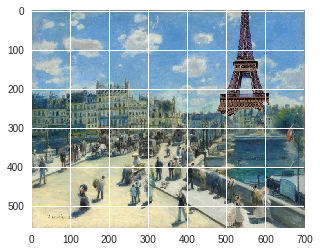

In [132]:
stage1_img = np.load(PATH/f'{idx}_stage1.npy')
stage1_tfm,_  = val_tfms(stage1_img, mask)
opt_img = input_tfm.copy()
plt.imshow(val_tfms.denorm(to_np(opt_img).transpose(1,2,0)));

In [133]:

opt_img_v = V(opt_img[None], requires_grad=True)
opt_img_v.shape

torch.Size([1, 3, 557, 700])

In [0]:
max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=0.1)

In [0]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter += 1
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss

In [138]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,final_loss))

Iteration: 100, loss: 0.0710512101650238
Iteration: 200, loss: 0.0378374382853508
Iteration: 300, loss: 0.03377018868923187
Iteration: 400, loss: 0.03231287747621536
Iteration: 500, loss: 0.03156691789627075
Iteration: 600, loss: 0.031117945909500122
Iteration: 700, loss: 0.030821193009614944
Iteration: 800, loss: 0.030603626742959023
Iteration: 900, loss: 0.03043992444872856
Iteration: 1000, loss: 0.03030790016055107


(-0.5, 699.5, 556.5, -0.5)

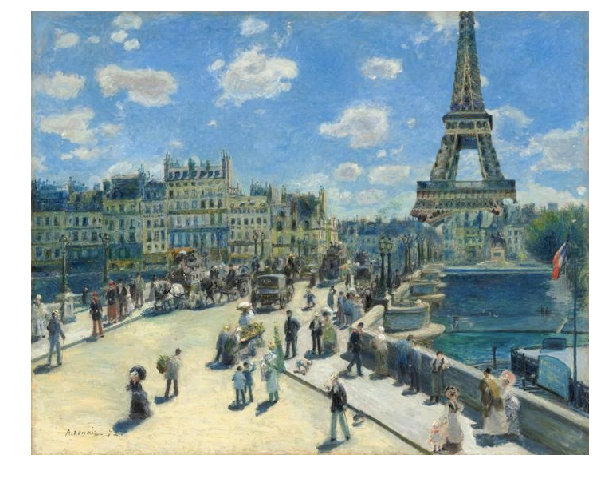

In [139]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
out_img = val_tfms.denorm(to_np(opt_img_v.data)[0].transpose(1,2,0))
out_img = out_img * mask_smth + style_img * (1-mask_smth)
out_img = out_img.clip(0,1)
ax.imshow(out_img)
ax.axis('off')